## Realistic distance measure using door information

In [5]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
# read room polygons in esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  # room polygon is the second layer in our gdb
doors = gpd.read_file(gdb_path, layer=1)  # room polygon is the second layer in our gdb


In [7]:
def ctr(geom):
    return geom.centroid

cent= doors.geometry.map(ctr)

Let's find which rooms are connected by each door. We will find two rooms within a certain raidus from a door. We need to handle exceptional cases like these. 

* less than two rooms are found
* more than rwo rooms are found
* multiple doors are connecting two rooms 

In [8]:
def find_rooms(door_center, rooms, radius):
    connected_rooms = list()
    door_buff = door_center.buffer(radius)
    for index, room in rooms.iterrows():
        if room.geometry.intersects(door_buff):
            connected_rooms.append(index)
    return connected_rooms

connected = doors.geometry.apply(find_rooms, args=(rooms, 0.02))
cnt = lambda x:len(x)
connected_cnt = connected.apply(cnt)
connected_cnt.value_counts()

2    249
1     19
Name: geometry, dtype: int64

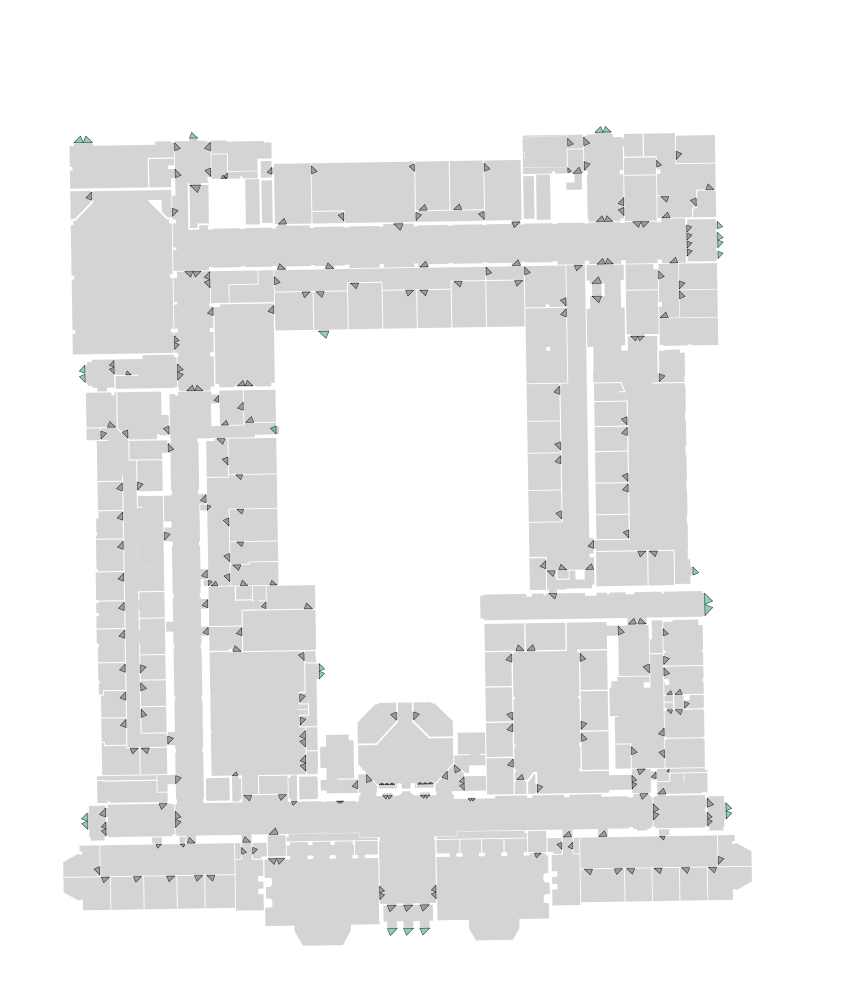

In [9]:
doors["connected_cnt"] = connected_cnt

# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
doors.plot(ax=ax, linewidth=0.3, column='connected_cnt', cmap='Dark2')
ax.set_aspect('equal')
plt.show()

In [10]:
print(connected)

0        [12, 15]
1        [12, 15]
2        [12, 15]
3            [12]
4            [12]
5            [12]
6        [94, 97]
7          [0, 8]
8          [0, 4]
9          [0, 3]
10         [0, 2]
11         [0, 5]
12         [0, 6]
13         [0, 1]
14       [7, 183]
15       [0, 183]
16      [30, 111]
17       [87, 94]
18      [98, 104]
19       [30, 78]
20         [7, 9]
21     [105, 106]
22       [75, 94]
23       [88, 94]
24       [93, 94]
25      [11, 185]
26         [0, 6]
27     [105, 183]
28      [98, 105]
29      [98, 100]
          ...    
238    [155, 169]
239    [165, 169]
240    [165, 169]
241    [153, 177]
242    [187, 198]
243    [187, 199]
244    [187, 200]
245    [187, 201]
246    [187, 202]
247    [187, 203]
248    [187, 204]
249    [187, 205]
250    [187, 206]
251    [187, 195]
252    [187, 194]
253    [187, 193]
254    [187, 209]
255    [187, 207]
256    [187, 196]
257    [187, 197]
258    [187, 208]
259    [187, 215]
260    [184, 215]
261    [184, 213]
262    [18

In [11]:
print(doors.head())

  BldRecNbr Floor  Shape_Area  Shape_Length  \
0   1000221    01    4.362544      9.283647   
1   1000221    01    4.362544      9.283647   
2   1000221    01    4.362300      9.283554   
3   1000221    01    5.278518     10.212051   
4   1000221    01    5.278604     10.211964   

                                            geometry  connected_cnt  
0  (POLYGON ((13293945.57939632 282518.6072834581...              2  
1  (POLYGON ((13293939.38221785 282518.5068897605...              2  
2  (POLYGON ((13293933.18536745 282518.4064960629...              2  
3  (POLYGON ((13293933.56660105 282509.6617454141...              1  
4  (POLYGON ((13293939.6906168 282509.7608267665,...              1  


In [12]:
node_door = gpd.GeoDataFrame(geometry=doors.geometry.centroid)

In [13]:
node_door["node_type"] = 'door'
node_door["sid"] = "d" + pd.Series(doors.index).apply(str) 
node_door = node_door.set_index("sid")

In [14]:
print(node_door.head())

                                        geometry node_type
sid                                                       
d0   POINT (13293943.69586614 282517.7911198586)      door
d1    POINT (13293937.49868767 282517.690726161)      door
d2    POINT (13293931.30172791 282517.590441823)      door
d3   POINT (13293931.49464129 282508.7638888906)      door
d4   POINT (13293937.61876641 282508.8629702528)      door


In [15]:
node_room = gpd.GeoDataFrame(geometry=rooms.geometry.centroid)
node_room["node_type"] = 'room'
node_room["sid"] = "r" + pd.Series(rooms.index).apply(str) 
node_room = node_room.set_index("sid")

In [16]:
nodes = node_door.append(node_room)
print(nodes.head())

                                        geometry node_type
sid                                                       
d0   POINT (13293943.69586614 282517.7911198586)      door
d1    POINT (13293937.49868767 282517.690726161)      door
d2    POINT (13293931.30172791 282517.590441823)      door
d3   POINT (13293931.49464129 282508.7638888906)      door
d4   POINT (13293937.61876641 282508.8629702528)      door


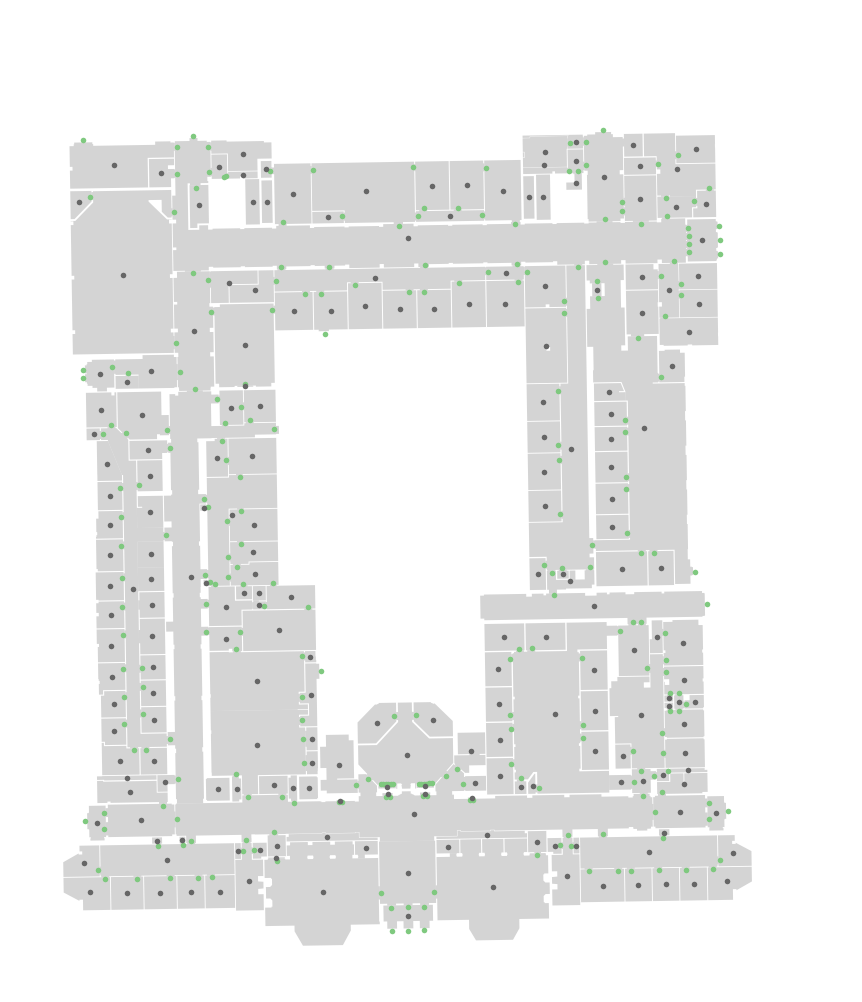

In [17]:
# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
ax.set_aspect('equal')
plt.show()

In [18]:
print(nodes.loc["d1"].geometry)

POINT (13293937.49868767 282517.690726161)


In [19]:
# let's make door-room connections

lines = {'geometry':[], 'from':[], 'to':[]}

for index, conn in enumerate(connected):
    for room in conn:
        did = "d" + str(index)
        rid = "r"  + str(room)
        door = nodes.loc[did]
        room = nodes.loc[rid]
        lines["from"].append(did)
        lines["to"].append(rid)
        lines["geometry"].append(LineString([door.geometry, room.geometry]))
        
# geodataframe for edges
edges = gpd.GeoDataFrame(lines)

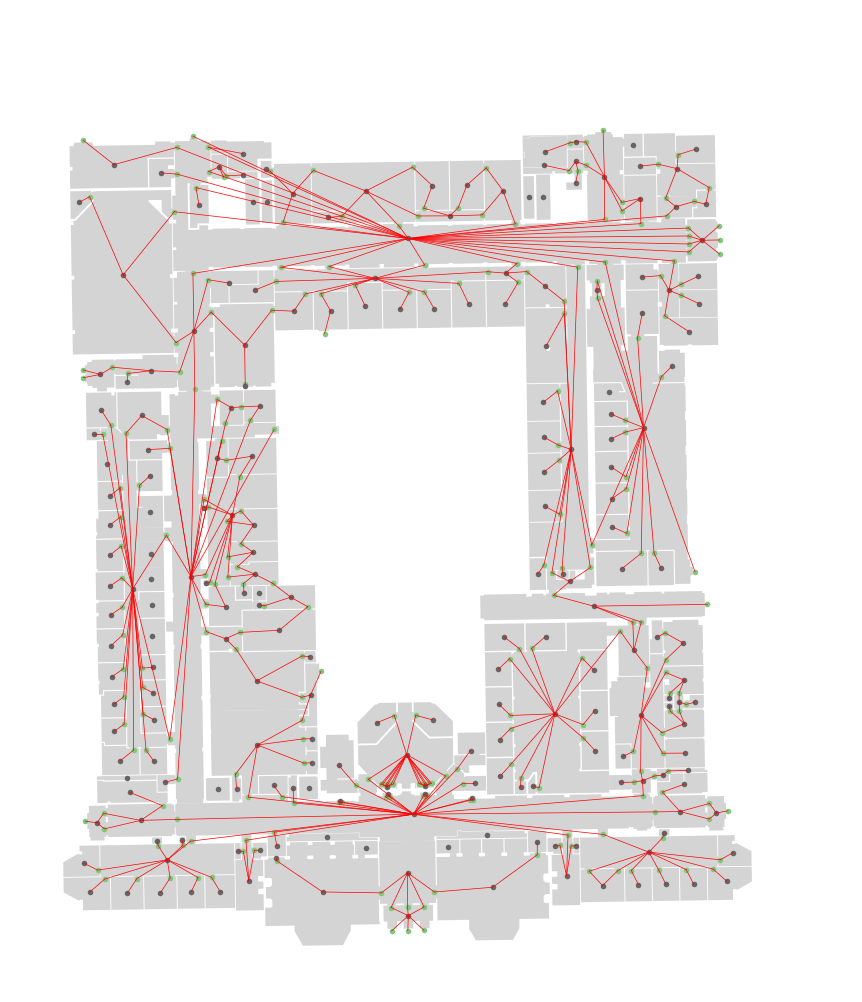

In [20]:
# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='r')
ax.set_aspect('equal')
plt.show()

In [34]:
# create room-to-room connection 
# if the distance between the two room < threshold
# if the two rooms are not connected by a door

def is_door_connected(rid1, rid2, room_connection):
    connected = False
    for conn in room_connection:
        if set([rid1, rid2]) == set(conn):
            connected = True
            return connected
    return connected
    

threshold = 0.02

# dictionary for edge geometry
room_adj = {'geometry':[], 'from':[], 'to':[]}

for index1, r1 in rooms.iterrows():
    for index2, r2 in rooms.iterrows():
        if r1.geometry.buffer(threshold).intersects(r2.geometry.buffer(threshold)) \
            and index1 > index2 \
            and not is_door_connected(index1, index2, connected):
            room_adj["from"].append("r" + str(index1))
            room_adj["to"].append("r" + str(index2))
            room_adj["geometry"].append(LineString([r1.geometry.centroid, r2.geometry.centroid]))

# geodataframe for edges
direct_connection = gpd.GeoDataFrame(room_adj)

In [35]:
print(direct_connection.head())

   from                                           geometry    to
0  r110  LINESTRING (13294017.67726923 282564.697533495...   r94
1  r133  LINESTRING (13293881.61083044 282631.364058402...   r38
2  r147  LINESTRING (13294011.60807119 282792.592652922...   r80
3  r152  LINESTRING (13293880.73375938 282602.889604288...  r150
4  r169  LINESTRING (13294026.32195661 282698.208244124...  r162


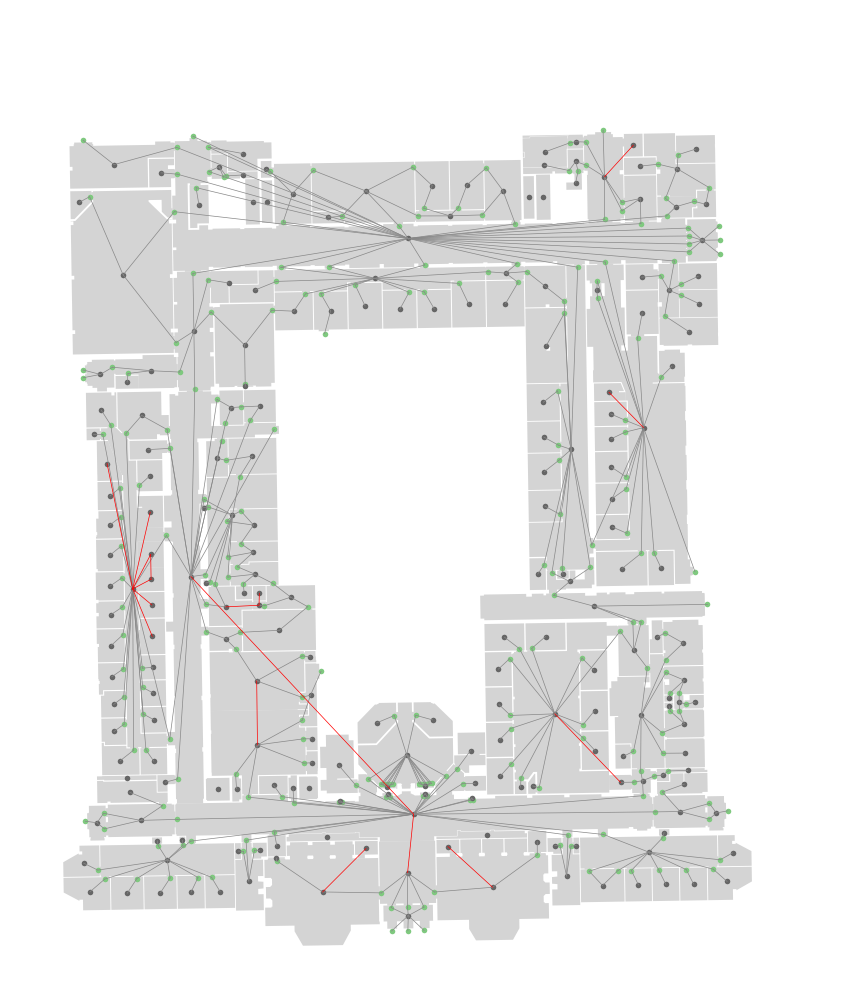

In [32]:
# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='#888888')
direct_connection.plot(ax=ax, linewidth=0.5, color='r')
ax.set_aspect('equal')
plt.show()

In [37]:
#looks good. let's append
edges = edges.append(direct_connection)

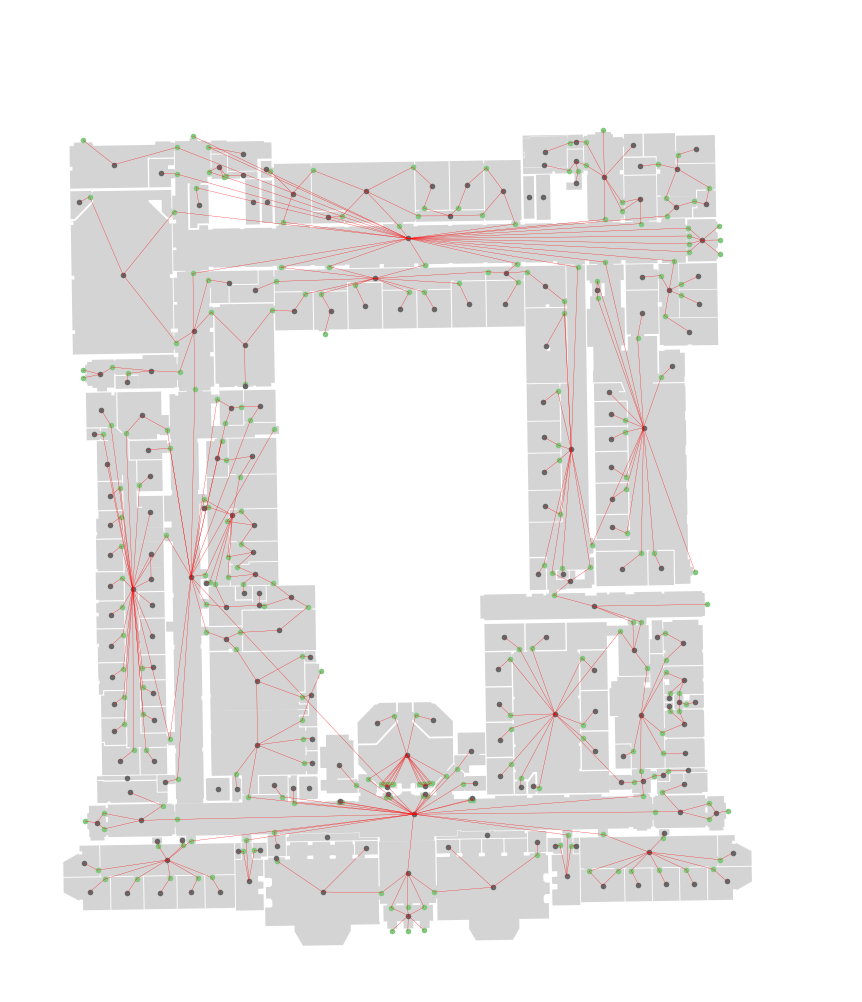

In [40]:
# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='red')
ax.set_aspect('equal')
plt.show()

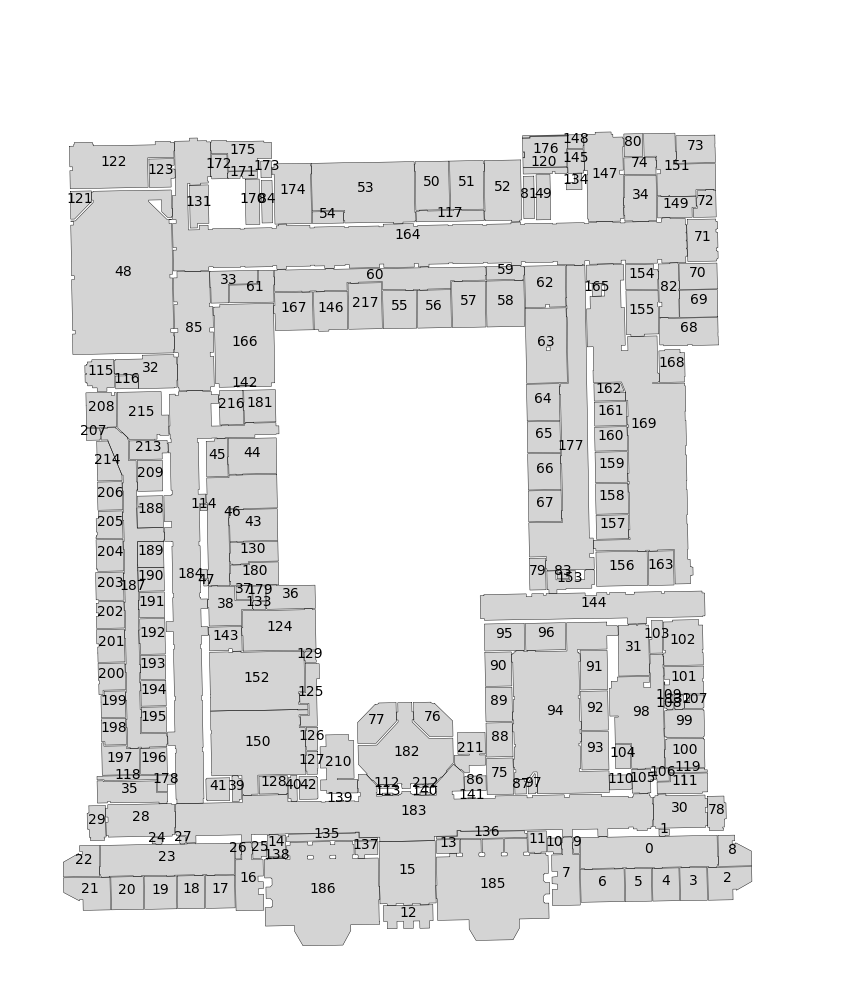

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
ax.set_aspect('equal')

for idx, row in rooms.iterrows():
    plt.annotate(s=idx, xy=[row.geometry.centroid.x, row.geometry.centroid.y],
                 horizontalalignment='center')
    
plt.show()



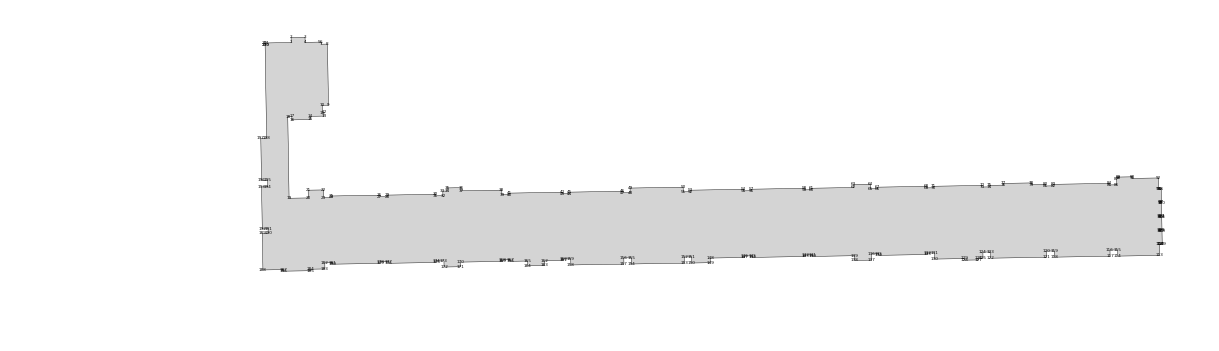

In [115]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.axison = False
rooms[rooms.index == 164].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
ax.set_aspect('equal')

p164 = rooms.loc[164].geometry[0]
boundary = p164.boundary.coords

for idx, row in enumerate(boundary):
    plt.annotate(s=idx, xy=row, horizontalalignment='center', fontsize=3)
    
plt.show()
fig.savefig("p164.pdf", format='pdf')

In [168]:
## I'd like cut the polygon with line 18-198, 19-194, 20-184, 83-119  
from shapely.geometry import MultiLineString
import shapely

rid = 164
cut_points = [(18,198), (19,194), (20,184), (83,119)]

room = rooms.loc[rid]
rpoly = room.geometry
rbound = rpoly[0].boundary.coords

lines = [LineString([rbound[p[0]], rbound[p[1]]]) for p in cut_points]
ml = MultiLineString(lines)

new_polys = list(shapely.ops.polygonize(rpoly.boundary.union(ml)))

add_rooms = gpd.GeoDataFrame({"geometry":new_polys})


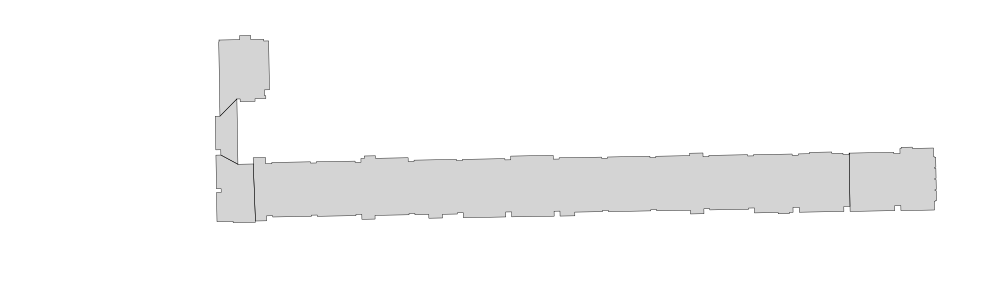

In [169]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
add_rooms.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
ax.set_aspect('equal')
    
plt.show()


